In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Preprocess data

In [2]:
# Import data
path = "../data/petdata_binary_1000_100.csv"
raw_data = pd.read_csv(path, index_col="doc_uri")
assert raw_data.shape == (1000,100), "Import error, df has false shape"

#### Conversion and cleaning
Surprise forces you to use schema \["user_id", "doc_id", "rating"\]

CF models are often sensitive to NA values -> replace NaN with 0 OR drop NaN. For demonstration purpose replacement used.

In [3]:
# Convert df
data = raw_data.unstack().to_frame().reset_index()
data.columns = ["user", "doc_uri", "rating"]

# Missing value handling
data.fillna(0, inplace=True)

assert data.shape == (raw_data.shape[0] * raw_data.shape[1], 3), "Conversion error, df has false shape"
assert data.rating.max() <= 1., "Value error, max rating over upper bound"
assert data.rating.min() >= -1., "Value error, min rating under lower bound"
data.head()

,user,doc_uri,rating
0,Aaron Keith III,http://www.vargas.biz/login.php,0.0
1,Aaron Keith III,http://wallace-walker.info/index/,0.0
2,Aaron Keith III,http://www.jimenez.biz/,0.0
3,Aaron Keith III,http://www.logan.com/about.html,1.0
4,Aaron Keith III,http://cox.org/list/tag/faq.html,0.0


### Descriptive statistics of ratings
Not meaningful <- randomly generated

In [4]:
data.rating.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
rating,100000.0,0.10561,0.405238,-1.0,0.0,0.0,0.0,1.0


In [5]:
data.rating.value_counts(normalize=True).to_frame().T

,0.0,1.0,-1.0
rating,0.82463,0.14049,0.03488


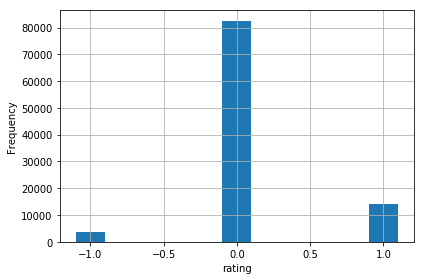

In [6]:
# Plot distribution of (random) ratings 

hist = data.rating.plot(kind="hist", grid=True,
                        bins=[-1.1,-0.9,-0.1,0.1,0.9,1.1])
hist.set(xlabel= "rating")

plt.tight_layout()
plt.savefig("plots/ratings_binary.png", orientation="landscape", dpi=120)

# Recommendation Engines

In [7]:
from surprise import KNNWithMeans, SVD, Dataset, Reader, NMF, accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.random_pred import NormalPredictor

reader = Reader(rating_scale=(-1, 1))
ds = Dataset.load_from_df(data[["user", "doc_uri", "rating"]], reader)

baseline_model = NormalPredictor() # Baseline model, predicts labels based on distribution of ratings

## Memory-based CF
#### User-based CF

In [8]:
sim_options = {"name": "cosine", # cosine similarity
               "user_based": True,  # user-based
               "min_support": 10 # min number of common items, else pred 0
               }

user_knn = KNNWithMeans(sim_options=sim_options)

#### Item-based CF

In [9]:
sim_options = {"name": "cosine", # cosine similarity
               "user_based": False,  # item-based
               "min_support": 5 # min number of common users, else pred 0
               }

item_knn = KNNWithMeans(sim_options=sim_options)

### Evaluation
Don't expect accurate models <- they are trained with random noise.

User- & item-based CF are slightly better than baseline model (predicts labels based on distribution of ratings). User-based approach works surprisingly better than item-based CF and is faster.

In [10]:
for algo_name, algo in zip(["Baseline", "User-based CF", "Item-based CF"],
                           [baseline_model, user_knn, item_knn]):
    history = cross_validate(algo, ds, measures=["RMSE", "MAE"], cv=5, verbose=False)
    print("***", algo_name, "***")
    print("RMSE: {:0.3f} (std {:0.4f}) <- {}".format(history["test_rmse"].mean(),
                                                     history["test_rmse"].std(),
                                                     history["test_rmse"]))
    print("MAE: {:0.3f} (std {:0.4f}) <- {}".format(history["test_mae"].mean(),
                                                     history["test_mae"].std(),
                                                     history["test_mae"]))
    print("Avg fit time: {:0.5f}s".format(np.array(history["fit_time"]).mean()))

*** Baseline ***
RMSE: 0.569 (std 0.0016) <- [0.56967698 0.57088725 0.56676103 0.57101653 0.56811232]
MAE: 0.438 (std 0.0008) <- [0.43865822 0.43838729 0.43740913 0.43881564 0.43682212]
Avg fit time: 0.06437s
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
*** User-based CF ***
RMSE: 0.407 (std 0.0028) <- [0.40609913 0.41177685 0.40622992 0.40640849 0.40310708]
MAE: 0.249 (std 0.0017) <- [0.24922004 0.25245081 0.24859084 0.2483961  0.24741573]
Avg fit time: 0.24327s
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similari

## Memory-based
Can we enhance performance of model by using memory-based techniques?

#### Matrix factorization-based CF

In [14]:
# Models - tune parameters, if you'd like ;)
svd = SVD() # Singular Value Decomposition
nmf = NMF() # Non-negative matrix factorization

### Evaluation
Don't expect accurate models <- they are trained with random noise

In [15]:
for algo_name, algo in zip(["Singular Value Decomposition", "Non-negative matrix factorization"],
                           [svd, nmf]):
    history = cross_validate(algo, ds, measures=["RMSE", "MAE"], cv=5, verbose=False)
    print("***", algo_name, "***")
    print("RMSE: {:0.3f} (std {:0.4f}) <- {}".format(history["test_rmse"].mean(),
                                                     history["test_rmse"].std(),
                                                     history["test_rmse"]))
    print("MAE: {:0.3f} (std {:0.4f}) <- {}".format(history["test_mae"].mean(),
                                                     history["test_mae"].std(),
                                                     history["test_mae"]))
    print("Avg fit time: {:0.5f}s".format(np.array(history["fit_time"]).mean()))

*** Singular Value Decomposition ***
RMSE: 0.409 (std 0.0016) <- [0.41019309 0.40551957 0.40895932 0.40953212 0.40891515]
MAE: 0.251 (std 0.0013) <- [0.25130988 0.24841961 0.25019144 0.25133748 0.25231599]
Avg fit time: 5.83796s
*** Non-negative matrix factorization ***
RMSE: 0.408 (std 0.0020) <- [0.41057056 0.40839747 0.40614848 0.40920141 0.40494778]
MAE: 0.240 (std 0.0013) <- [0.24168741 0.24044018 0.23908175 0.24158679 0.23837459]
Avg fit time: 6.20084s


In [ ]:
#FIXME

## Final model and predictions
kNN Basic looks most promising so far, so go for this one

#### Train & evaluate final model

In [11]:
# Train final model
trainset = ds.build_full_trainset()
knn.fit(trainset)

# RMSE of final model
testset = trainset.build_testset()
test_pred = knn.test(testset)
accuracy.rmse(test_pred, verbose=True) # should be very bad ;)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3321


1.3321412404968649

#### Predict some document ratings

In [12]:
combinations_to_predict = [("Aaron Keith III", "http://gregory.com/"),
                           ("Abigail Wong", "http://hicks.com/"),
                           ("Julie Bullock", "https://www.garcia.com/"),
                           ("Victoria Perez", "http://lee-phillips.org/register/")]

In [13]:
# Predictions
for combination in combinations_to_predict:
    user = combination[0]
    doc = combination[1]
    pred = knn.predict(user, doc)
    print(pred[0], "should rate", pred[1], "with", int(round(pred[3])), "stars")

Aaron Keith III should rate http://gregory.com/ with 1 stars
Abigail Wong should rate http://hicks.com/ with 1 stars
Julie Bullock should rate https://www.garcia.com/ with 1 stars
Victoria Perez should rate http://lee-phillips.org/register/ with 2 stars
